In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import sklearn.preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
CONV_FILE = 'results/cudnn/conv.csv'
GEMM_FILE = 'results/cudnn/gemm.csv'

In [2]:
def load_csv(file):
    return pd.read_csv(file)

In [3]:
def one_hot_encode_conv(df):
    precision = pd.get_dummies(df.precision)
    fwd_algo = pd.get_dummies(df.fwd_algo)
    df.drop(columns=['precision', 'fwd_algo'], inplace=True)
    df = pd.concat([df, precision, fwd_algo], axis=1)

    print(f'New encoded columns: {precision.columns, fwd_algo.columns}')
    return df

In [4]:
def one_hot_encode_gemm(df):
    precision = pd.get_dummies(df.precision)
    df.drop(columns=['precision'], inplace=True)
    df = pd.concat([df, precision], axis=1)

    print(f'New encoded columns: {precision.columns}')
    return df

In [5]:
def normalize(X, y):
    ss = StandardScaler()
    X = pd.DataFrame(ss.fit_transform(X))
    y = pd.Series(ss.fit_transform(np.array(y).reshape(-1,1))[:,0])
    return X, y

def prune_columns_conv(df):
    # Drop columns that only have one value (i.e. same number of threads per block across all architectures, etc)
    unique = df.nunique() == 1
    drop_idx = unique[unique == True].index.array
    df.drop(columns=drop_idx, inplace=True)

    drop_cols = ['sm_cap', 'cuda_version', 'h', 'f_h']
    df.drop(columns=drop_cols, inplace=True)

    print('Dropped columns: ', drop_idx, drop_cols)
    return df

In [6]:
def prune_columns_gemm(df):
    # Drop columns that only have one value (i.e. same number of threads per block across all architectures, etc)
    unique = df.nunique() == 1
    drop_idx = unique[unique == True].index.array
    df.drop(columns=drop_idx, inplace=True)

    drop_cols = ['sm_cap', 'cuda_version']
    df.drop(columns=drop_cols, inplace=True)

    print('Dropped columns: ', drop_idx, drop_cols)
    return df



In [7]:
df = load_csv(CONV_FILE)
df = prune_columns_conv(df)
df = one_hot_encode_conv(df)
print(df.info())
print(df.describe())

Dropped columns:  <PandasArray>
[                'total_const_mem',      'total_shared_mem_per_block',
         'total_num_reg_per_block',                       'warp_size',
           'max_threads_per_block',                 'gpu_sharing_mem',
            'host_page_locked_mem',                     'ecc_support',
              'unified_addressing',              'compute_preemption',
       'cooperative_kernel_launch', 'multi_device_cooperative_kernel']
Length: 12, dtype: object ['sm_cap', 'cuda_version', 'h', 'f_h']
New encoded columns: (Index(['float', 'half', 'int8'], dtype='object'), Index(['FFT', 'FFT_TILING', 'GEMM', 'IMPLICIT_GEMM', 'IMPLICIT_PRECOMP_GEMM',
       'WINOGRAD', 'WINOGRAD_NONFUSED'],
      dtype='object'))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52337 entries, 0 to 52336
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   w                      52337 non-null  int64 

array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'f_w'}>,
        <AxesSubplot:title={'center':'pad_w'}>],
       [<AxesSubplot:title={'center':'pad_h'}>,
        <AxesSubplot:title={'center':'stride_w'}>,
        <AxesSubplot:title={'center':'stride_h'}>,
        <AxesSubplot:title={'center':'fwd_time(usec)'}>,
        <AxesSubplot:title={'center':'pad_kernels'}>,
        <AxesSubplot:title={'center':'global_mem_bytes'}>],
       [<AxesSubplot:title={'center':'cuda_cores'}>,
        <AxesSubplot:title={'center':'max_clock_rate_Mhz'}>,
        <AxesSubplot:title={'center':'mem_clock_rate_Mhz'}>,
        <AxesSubplot:title={'center':'mem_bus_width'}>,
        <AxesSubplot:title={'center':'l2_cache_size'}>,
        <AxesSubplot:title={'center':'max_threads_per_mp'}>],
       [<AxesSubplot:title={'center':'bandwidth_GBps'}>,
  

<Figure size 432x288 with 0 Axes>

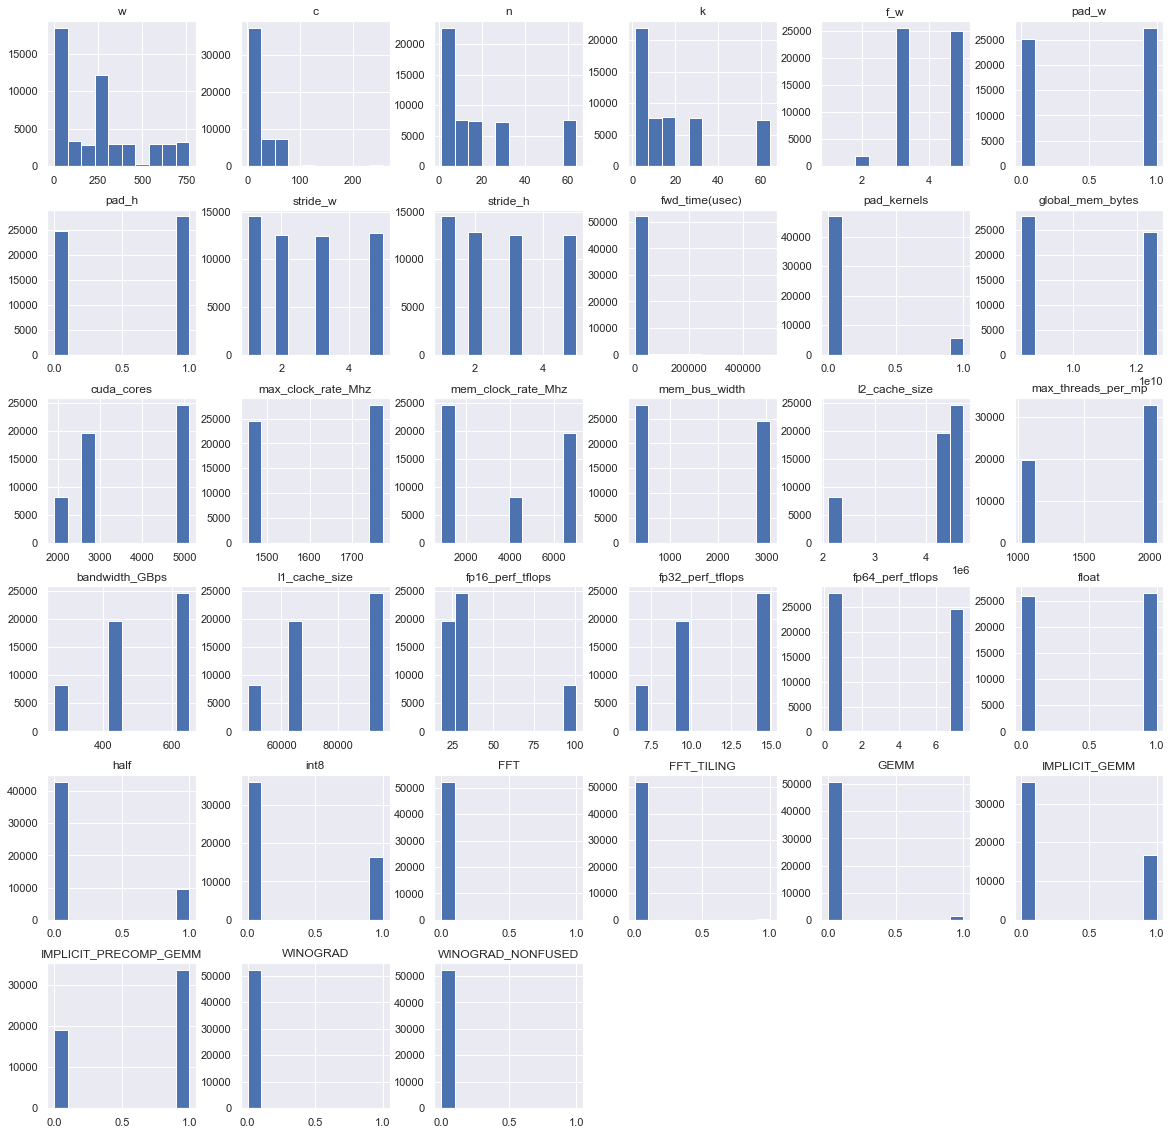

In [8]:
fig = plt.figure()
df.hist(figsize=(20,20))

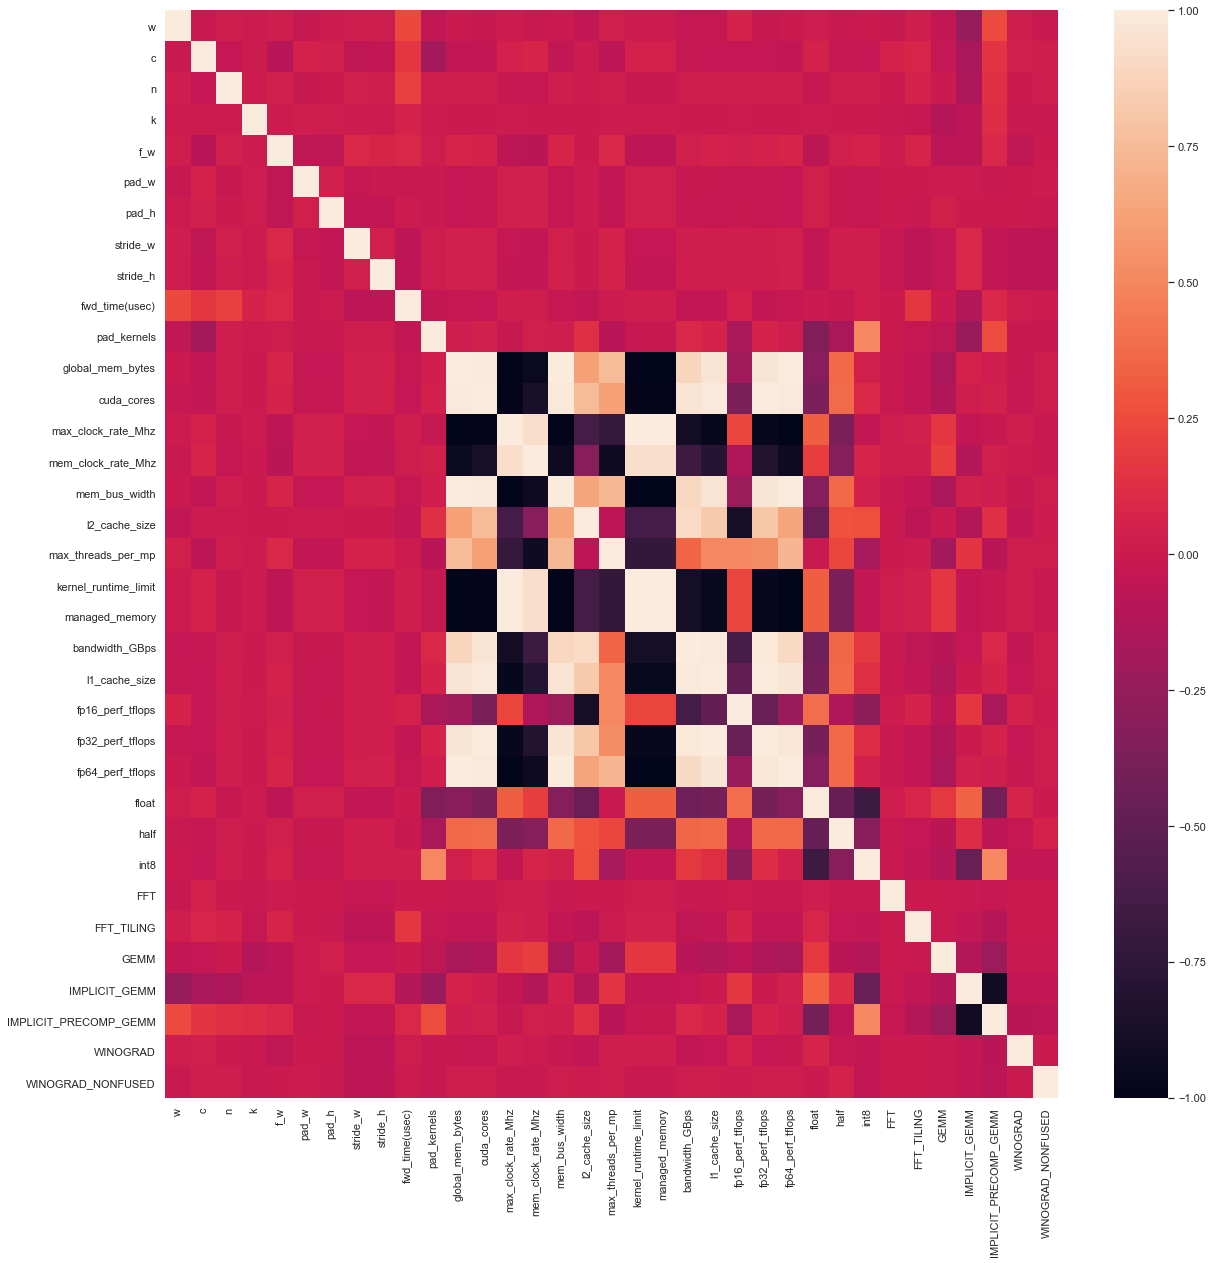

In [9]:
fig = plt.figure(figsize=(20,20))
ax = sns.heatmap(df.corr())

In [10]:
y = df['fwd_time(usec)']
X = df.drop(columns=['fwd_time(usec)'])

X, y = normalize(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [11]:
clf = MLPRegressor(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.5201920292880117

In [12]:
clf = LinearRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.16552590536922251

In [13]:
clf = Ridge()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.16552618213536585

In [14]:
clf = Lasso(alpha=0.1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.10318399527609323

In [15]:
clf = SVR()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.41777606412333046

In [16]:
clf = KNeighborsRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.46488896667890833

In [17]:
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5960972878898567

In [18]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7770151067093115

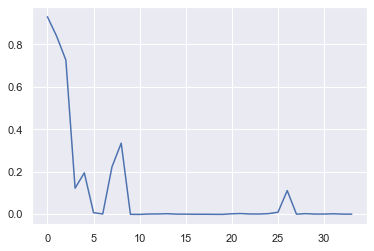

In [19]:
random_forest_result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
plt.plot(random_forest_result.importances_mean)

In [20]:
importances = pd.Series(random_forest_result.importances_mean).sort_values(ascending=False)
idx = importances[importances > 0.003].index

In [21]:
imp = []
for x, y in zip(df.columns[idx], importances[importances > 0.003].values):
    imp.append((x, y))
print('Most "important" columns in dataset: ')
imp

Most "important" columns in dataset: 


[('w', 0.9300327498032459),
 ('c', 0.8383145279035948),
 ('n', 0.7259296677575843),
 ('stride_h', 0.3343371118644686),
 ('stride_w', 0.22274369365322114),
 ('f_w', 0.19458329235673483),
 ('k', 0.12222193433505076),
 ('half', 0.11101794291131122),
 ('float', 0.00890537770826616),
 ('pad_w', 0.0068226463775879044)]

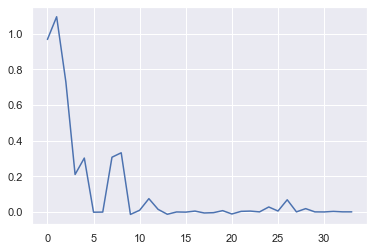

In [22]:
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)

decision_tree_results = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
plt.plot(decision_tree_results.importances_mean)


In [23]:
importances = pd.Series(decision_tree_results.importances_mean).sort_values(ascending=False)
idx = importances[importances > 0.003].index

In [24]:
imp = []
for x, y in zip(df.columns[idx], importances[importances > 0.003].values):
    imp.append((x, y))
print('Most "important" columns in dataset: ')
imp

Most "important" columns in dataset: 


[('c', 1.0951346779030924),
 ('w', 0.9676225801383239),
 ('n', 0.7291562617831364),
 ('stride_h', 0.33157754380317844),
 ('stride_w', 0.3066718412278764),
 ('f_w', 0.30196345727151436),
 ('k', 0.20977106943652624),
 ('global_mem_bytes', 0.07409478377095192),
 ('half', 0.06780303679109434),
 ('fp64_perf_tflops', 0.027413047117871736),
 ('FFT', 0.018136237541925913),
 ('cuda_cores', 0.01402786317465804),
 ('pad_kernels', 0.009067050229809193),
 ('managed_memory', 0.006794287636664597),
 ('float', 0.004663293481541275),
 ('l2_cache_size', 0.0043439438651729275),
 ('fp16_perf_tflops', 0.0043296266520631566)]

In [25]:
# BEGIN GEMM


In [26]:
df = load_csv(GEMM_FILE)
df = prune_columns_gemm(df)
df = one_hot_encode_gemm(df)
print(df.info())
print(df.describe())

Dropped columns:  <PandasArray>
[                'total_const_mem',      'total_shared_mem_per_block',
         'total_num_reg_per_block',                       'warp_size',
           'max_threads_per_block',                 'gpu_sharing_mem',
            'host_page_locked_mem',                     'ecc_support',
              'unified_addressing',              'compute_preemption',
       'cooperative_kernel_launch', 'multi_device_cooperative_kernel']
Length: 12, dtype: object ['sm_cap', 'cuda_version']
New encoded columns: Index(['float', 'half'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40965 entries, 0 to 40964
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   m                     40965 non-null  int64  
 1   n                     40965 non-null  int64  
 2   k                     40965 non-null  int64  
 3   a_t                   40965 non-null  int64  
 4   b_t    

array([[<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'a_t'}>],
       [<AxesSubplot:title={'center':'b_t'}>,
        <AxesSubplot:title={'center':'time(usec)'}>,
        <AxesSubplot:title={'center':'global_mem_bytes'}>,
        <AxesSubplot:title={'center':'cuda_cores'}>],
       [<AxesSubplot:title={'center':'max_clock_rate_Mhz'}>,
        <AxesSubplot:title={'center':'mem_clock_rate_Mhz'}>,
        <AxesSubplot:title={'center':'mem_bus_width'}>,
        <AxesSubplot:title={'center':'l2_cache_size'}>],
       [<AxesSubplot:title={'center':'max_threads_per_mp'}>,
        <AxesSubplot:title={'center':'bandwidth_GBps'}>,
        <AxesSubplot:title={'center':'l1_cache_size'}>,
        <AxesSubplot:title={'center':'fp16_perf_tflops'}>],
       [<AxesSubplot:title={'center':'fp32_perf_tflops'}>,
        <AxesSubplot:title={'center':'fp64_perf_tflops'}>,
        <AxesSubplot:t

<Figure size 432x288 with 0 Axes>

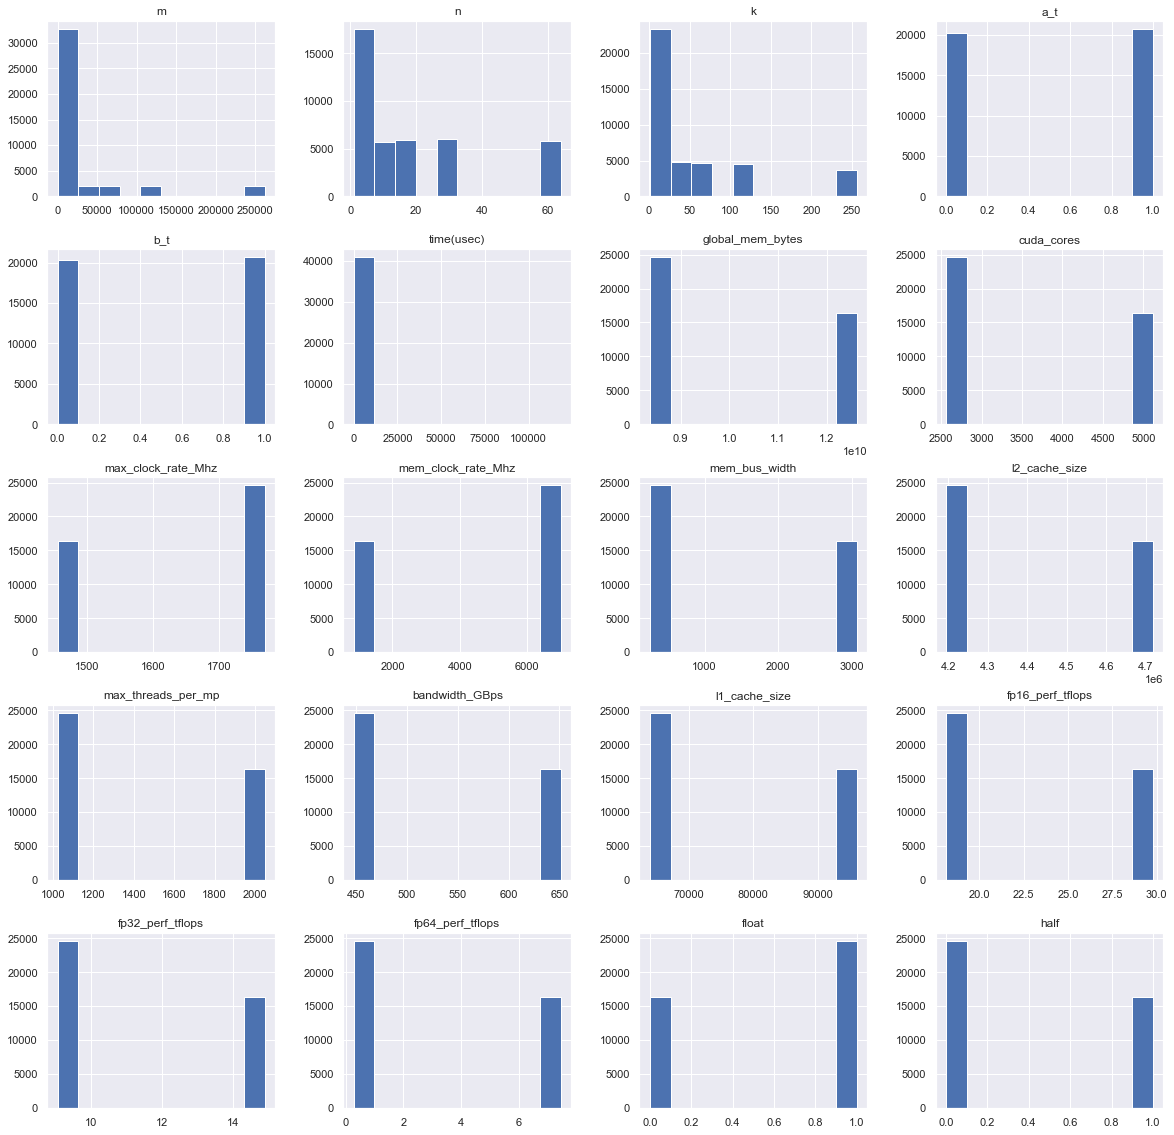

In [27]:
fig = plt.figure()
df.hist(figsize=(20,20))

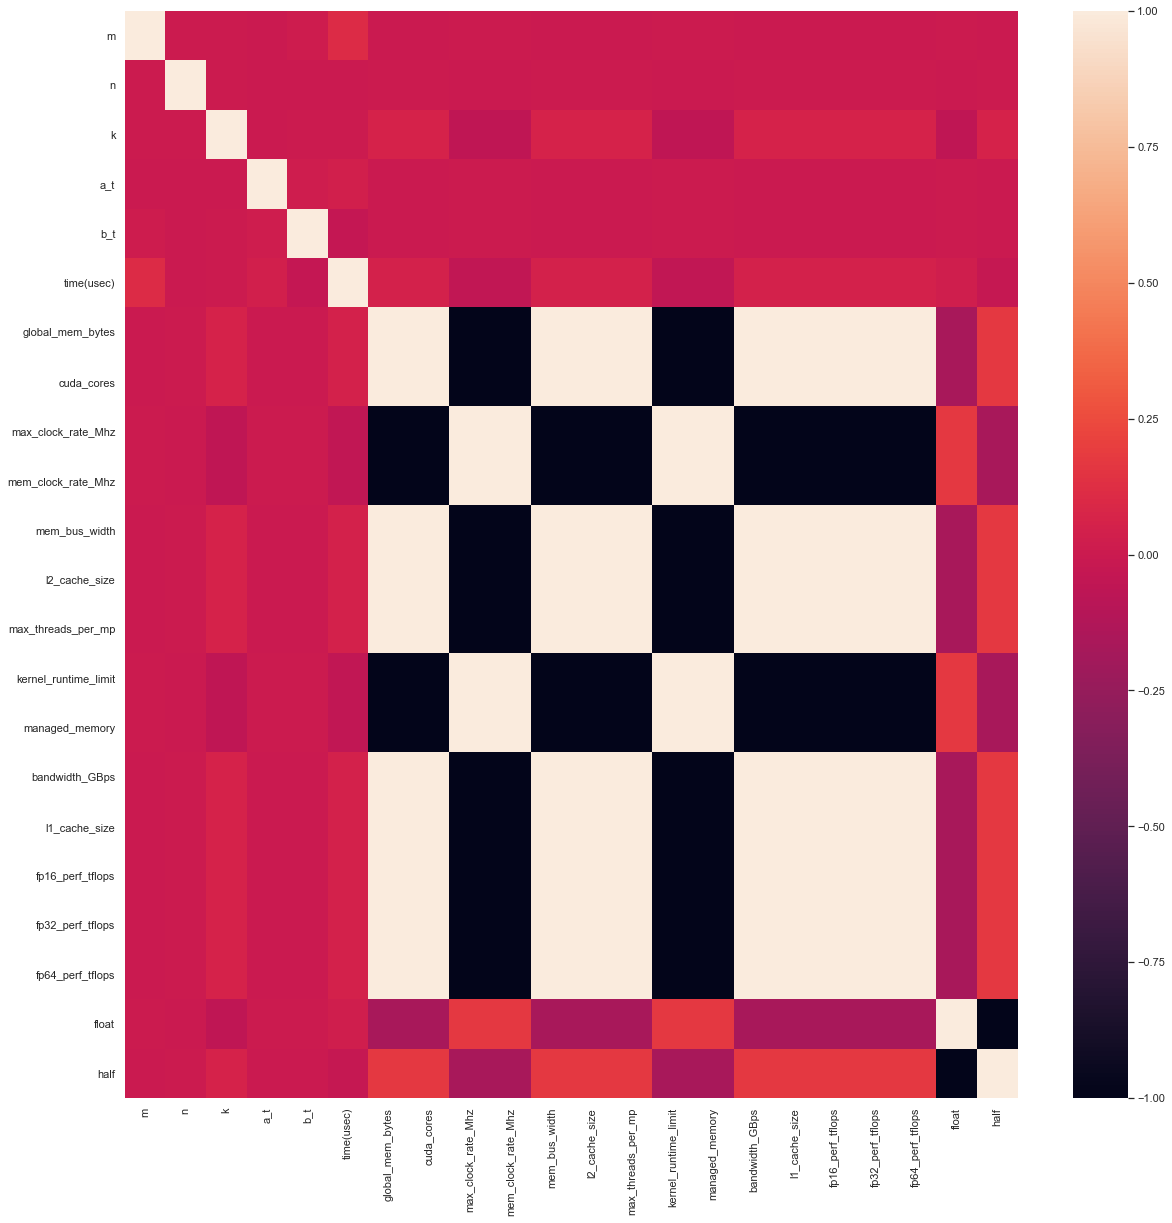

In [28]:
fig = plt.figure(figsize=(20,20))
ax = sns.heatmap(df.corr())

In [29]:
y = df['time(usec)']
X = df.drop(columns=['time(usec)'])

X, y = normalize(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

(array([14.,  0.,  0.,  1.,  0.,  1.,  2.,  0.,  2.,  1.]),
 array([0.        , 0.16373056, 0.32746113, 0.49119169, 0.65492226,
        0.81865282, 0.98238339, 1.14611395, 1.30984452, 1.47357508,
        1.63730565]),
 <BarContainer object of 10 artists>)

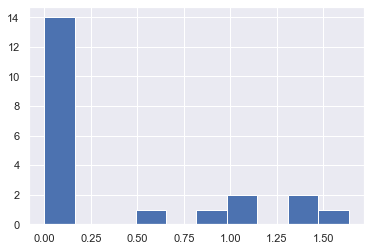

In [30]:

clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)

decision_tree_results = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
plt.hist(decision_tree_results.importances_mean)


In [31]:
importances = pd.Series(decision_tree_results.importances_mean).sort_values(ascending=False)
idx = importances[importances > 0.003].index

In [32]:
df.drop(columns=['time(usec)'], inplace=True)

imp = []
for x, y in zip(df.columns[idx], importances[importances > 0.003].values):
    imp.append((x, y))
print('Most "important" columns in dataset: ')
imp

Most "important" columns in dataset: 


[('k', 1.6373056464840001),
 ('n', 1.408239341514839),
 ('m', 1.3864991767930337),
 ('b_t', 1.0710232705138403),
 ('float', 0.9978457711531863),
 ('fp16_perf_tflops', 0.8790157021421445),
 ('a_t', 0.6283318244487168),
 ('max_clock_rate_Mhz', 0.08607460716638002)]

In [33]:
df.kernel_runtime_limit.value_counts()

True     24579
False    16386
Name: kernel_runtime_limit, dtype: int64

In [34]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9967743416407036

(array([15.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.]),
 array([7.56141387e-04, 1.53269318e-01, 3.05782495e-01, 4.58295672e-01,
        6.10808850e-01, 7.63322027e-01, 9.15835204e-01, 1.06834838e+00,
        1.22086156e+00, 1.37337473e+00, 1.52588791e+00]),
 <BarContainer object of 10 artists>)

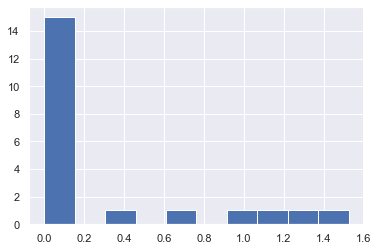

In [35]:
random_forest_result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
plt.hist(random_forest_result.importances_mean)

In [36]:
importances = pd.Series(random_forest_result.importances_mean).sort_values(ascending=False)
idx = importances[importances > 0.003].index

In [37]:
imp = []
for x, y in zip(df.columns[idx], importances[importances > 0.003].values):
    imp.append((x, y))
print('Most "important" columns in dataset: ')
imp

Most "important" columns in dataset: 


[('k', 1.5258879117576416),
 ('m', 1.346419320984945),
 ('n', 1.2092532901364108),
 ('b_t', 1.0009019901390015),
 ('a_t', 0.6245725781431097),
 ('float', 0.4340076747710885),
 ('half', 0.11886926326500305),
 ('mem_clock_rate_Mhz', 0.01730343815346682),
 ('l2_cache_size', 0.012303384472286094),
 ('max_clock_rate_Mhz', 0.012046309202711703),
 ('cuda_cores', 0.011934491847689155),
 ('managed_memory', 0.011831820151052986),
 ('kernel_runtime_limit', 0.01019422563002883),
 ('global_mem_bytes', 0.009445728701265888),
 ('max_threads_per_mp', 0.007300079813361238),
 ('fp32_perf_tflops', 0.006880254594900548),
 ('fp64_perf_tflops', 0.005411948176068026),
 ('bandwidth_GBps', 0.0038928025998775317),
 ('fp16_perf_tflops', 0.003558616729252906),
 ('mem_bus_width', 0.0031377635401953707)]